# Mitigating the Domain Gap using Fine-Tuning

## 1. Pre-train the network using "RA" features

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
data = pd.read_csv('data/DSA_features.csv')
data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1


In [3]:
le_activity = LabelEncoder()
data['activity'] = le_activity.fit_transform(data['activity'])

le_people = LabelEncoder()
data['people'] = le_people.fit_transform(data['people'])

data.head()

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,12,0
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,12,0
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,12,0
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,12,0
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,12,0


In [4]:
# X = data.drop(['activity'], axis=1).values
X = data.filter(regex='RA_').values
# X_LA = data.filter(regex='LA_') 
y = data['activity'].values

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

(5107, 54) (1277, 54) (2736, 54)


In [6]:
class DSASequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=3):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])

In [7]:
train_dataset = DSASequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DSASequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DSASequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
class DSALSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DSALSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 64
num_layers = 1
num_classes = len(np.unique(y))
net = DSALSTMClassifier(X.shape[1], hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
num_epochs = 50
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/50], Train Accuracy: 0.9132, Validation Accuracy: 0.8714
Epoch [20/50], Train Accuracy: 0.9794, Validation Accuracy: 0.9122
Epoch [30/50], Train Accuracy: 0.9973, Validation Accuracy: 0.9341
Epoch [40/50], Train Accuracy: 0.9998, Validation Accuracy: 0.9349
Epoch [50/50], Train Accuracy: 1.0000, Validation Accuracy: 0.9380


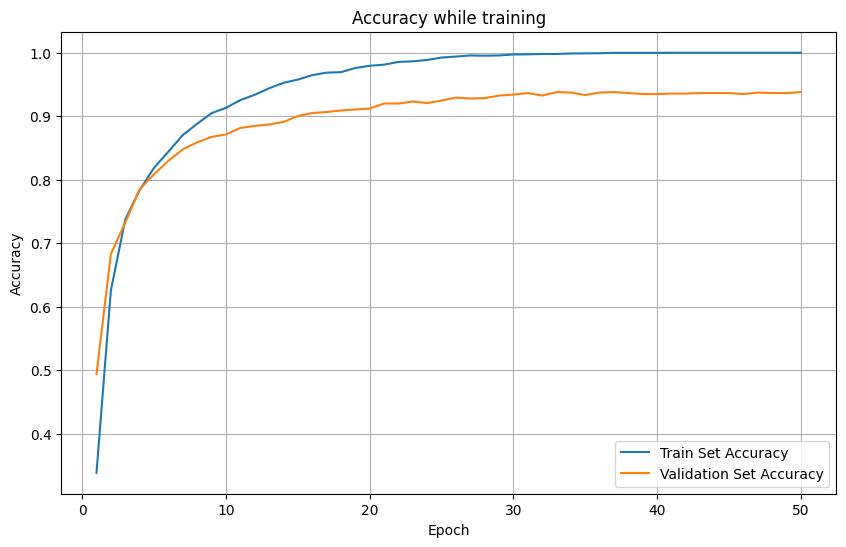

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [12]:
net.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9481


In [13]:
model_save_path = 'trained_nets/ra_trained_model.pth'
torch.save(net.state_dict(), model_save_path)

## 2. Evalute pre-trained net on "LA" features

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

In [4]:
data = pd.read_csv('data/DSA_features.csv')

In [5]:
le_activity = LabelEncoder()
data['activity'] = le_activity.fit_transform(data['activity'])

le_people = LabelEncoder()
data['people'] = le_people.fit_transform(data['people'])

In [6]:
# X = data.drop(['activity'], axis=1).values
X = data.filter(regex='LA_').values
# X_LA = data.filter(regex='LA_') 
y = data['activity'].values

In [7]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

(5107, 54) (1277, 54) (2736, 54)


In [8]:
class DSASequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=3):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])

In [9]:
train_dataset = DSASequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DSASequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DSASequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
class DSALSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DSALSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_save_path = 'trained_nets/ra_trained_model.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 64
num_layers = 1
num_classes = len(np.unique(y))
net = DSALSTMClassifier(X.shape[1], hidden_size, num_layers, num_classes)

net.load_state_dict(torch.load(model_save_path))
net.to(device)

/var/folders/7d/n6nvf8n51ws86n2p2yx5ks_80000gn/T/ipykernel_16923/2388142048.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_save_pa

DSALSTMClassifier(
  (lstm): LSTM(54, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=19, bias=True)
)

In [17]:
net.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.3837


## 3. Fine-tune pre-trained nets on "LA" features

### 3-1. Baseline

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

In [20]:
data = pd.read_csv('data/DSA_features.csv')
le_activity = LabelEncoder()
data['activity'] = le_activity.fit_transform(data['activity'])

le_people = LabelEncoder()
data['people'] = le_people.fit_transform(data['people'])

In [22]:
X = data.filter(regex='LA_').values
y = data['activity'].values

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

(5107, 54) (1277, 54) (2736, 54)


In [24]:
class DSASequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=3):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])

In [25]:
train_dataset = DSASequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DSASequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DSASequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
class DSALSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DSALSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_size = 64
num_layers = 1
num_classes = len(np.unique(y))
net = DSALSTMClassifier(X.shape[1], hidden_size, num_layers, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [28]:
num_epochs = 50
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/50], Train Accuracy: 0.9418, Validation Accuracy: 0.8910
Epoch [20/50], Train Accuracy: 0.9849, Validation Accuracy: 0.9231
Epoch [30/50], Train Accuracy: 0.9994, Validation Accuracy: 0.9278
Epoch [40/50], Train Accuracy: 1.0000, Validation Accuracy: 0.9294
Epoch [50/50], Train Accuracy: 1.0000, Validation Accuracy: 0.9255


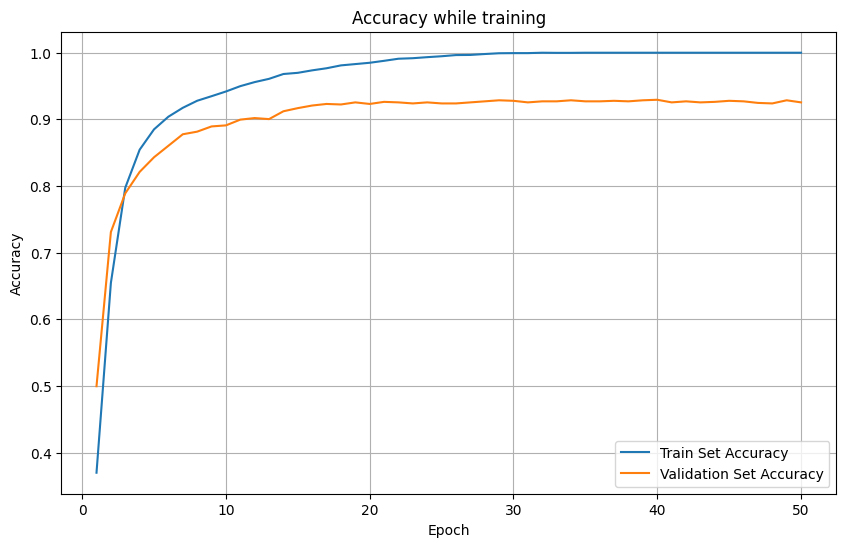

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [30]:
net.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9429


### 3-2. Linear Layer Only

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

In [13]:
data = pd.read_csv('data/DSA_features.csv')
le_activity = LabelEncoder()
data['activity'] = le_activity.fit_transform(data['activity'])

le_people = LabelEncoder()
data['people'] = le_people.fit_transform(data['people'])

X = data.filter(regex='LA_').values
y = data['activity'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

(5107, 54) (1277, 54) (2736, 54)


In [14]:
class DSASequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=3):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])
    
train_dataset = DSASequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DSASequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DSASequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
class DSALSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DSALSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_save_path = 'trained_nets/ra_trained_model.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 64
num_layers = 1
num_classes = len(np.unique(y))
net = DSALSTMClassifier(X.shape[1], hidden_size, num_layers, num_classes)

net.load_state_dict(torch.load(model_save_path))
net.to(device)
for param in net.parameters():
    param.requires_grad = False
for param in net.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.fc.parameters(), lr=0.001)

/var/folders/7d/n6nvf8n51ws86n2p2yx5ks_80000gn/T/ipykernel_17901/4002914109.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_save_pa

In [17]:
num_epochs = 200
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/200], Train Accuracy: 0.7667, Validation Accuracy: 0.7388
Epoch [20/200], Train Accuracy: 0.8629, Validation Accuracy: 0.8353
Epoch [30/200], Train Accuracy: 0.8913, Validation Accuracy: 0.8620
Epoch [40/200], Train Accuracy: 0.9081, Validation Accuracy: 0.8784
Epoch [50/200], Train Accuracy: 0.9179, Validation Accuracy: 0.8910
Epoch [60/200], Train Accuracy: 0.9240, Validation Accuracy: 0.8980
Epoch [70/200], Train Accuracy: 0.9297, Validation Accuracy: 0.9020
Epoch [80/200], Train Accuracy: 0.9342, Validation Accuracy: 0.9035
Epoch [90/200], Train Accuracy: 0.9395, Validation Accuracy: 0.9027
Epoch [100/200], Train Accuracy: 0.9416, Validation Accuracy: 0.9090
Epoch [110/200], Train Accuracy: 0.9444, Validation Accuracy: 0.9090
Epoch [120/200], Train Accuracy: 0.9444, Validation Accuracy: 0.9098
Epoch [130/200], Train Accuracy: 0.9457, Validation Accuracy: 0.9129
Epoch [140/200], Train Accuracy: 0.9477, Validation Accuracy: 0.9145
Epoch [150/200], Train Accuracy: 0.9483, Va

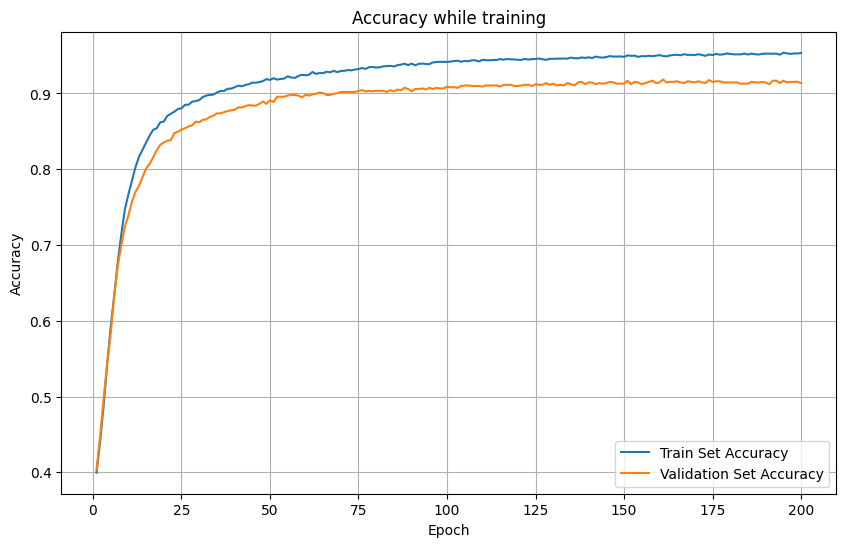

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [19]:
net.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9214


### 3-3. Full Model Fine-tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
data = pd.read_csv('data/DSA_features.csv')
le_activity = LabelEncoder()
data['activity'] = le_activity.fit_transform(data['activity'])

le_people = LabelEncoder()
data['people'] = le_people.fit_transform(data['people'])

X = data.filter(regex='LA_').values
y = data['activity'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

(5107, 54) (1277, 54) (2736, 54)


In [3]:
class DSASequenceDataset(Dataset):
    def __init__(self, X, y, sequence_length=3):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, idx):
        return (self.X[idx:idx+self.sequence_length], self.y[idx+self.sequence_length-1])
    
train_dataset = DSASequenceDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = DSASequenceDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = DSASequenceDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
class DSALSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(DSALSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_save_path = 'trained_nets/ra_trained_model.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hidden_size = 64
num_layers = 1
num_classes = len(np.unique(y))
net = DSALSTMClassifier(X.shape[1], hidden_size, num_layers, num_classes)

net.load_state_dict(torch.load(model_save_path))
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

/var/folders/7d/n6nvf8n51ws86n2p2yx5ks_80000gn/T/ipykernel_18084/2907277964.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_save_pa

In [6]:
num_epochs = 100
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    net.train()
    train_correct = 0
    train_total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    net.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [10/100], Train Accuracy: 0.9673, Validation Accuracy: 0.8941
Epoch [20/100], Train Accuracy: 0.9955, Validation Accuracy: 0.9200
Epoch [30/100], Train Accuracy: 0.9992, Validation Accuracy: 0.9255
Epoch [40/100], Train Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch [50/100], Train Accuracy: 1.0000, Validation Accuracy: 0.9318
Epoch [60/100], Train Accuracy: 1.0000, Validation Accuracy: 0.9318
Epoch [70/100], Train Accuracy: 1.0000, Validation Accuracy: 0.9318
Epoch [80/100], Train Accuracy: 1.0000, Validation Accuracy: 0.9349
Epoch [90/100], Train Accuracy: 1.0000, Validation Accuracy: 0.9333
Epoch [100/100], Train Accuracy: 1.0000, Validation Accuracy: 0.9333


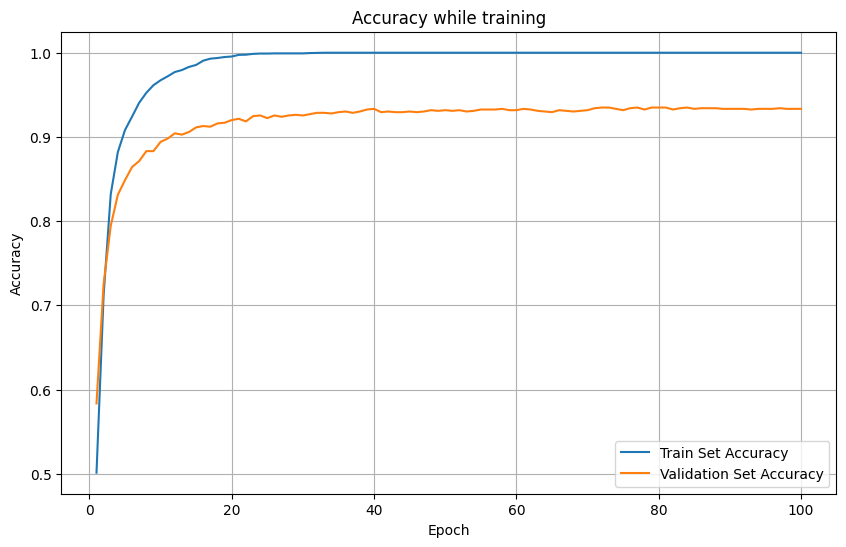

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Set Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Set Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy while training')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

In [8]:
net.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9396
